In [1]:
import numpy as np
import talib as ta
import pandas as pd
import datetime as dt
import yfinance as yf 
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

rcParams['figure.figsize'] =(16, 4) # setting thed default figure size to be 16x4 
sns.set_style('darkgrid')  # setting the default style to darkgrid 

In [2]:
# Data fetching and feature engineering

eth = yf.download('ETH-USD', start='2020-01-01', end=dt.date.today(), interval='1D')
eth['return'] = eth.Close.pct_change()
eth['ma'] = eth.Close.rolling(window=20, min_periods=1).mean()
ma = eth['ma']


[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

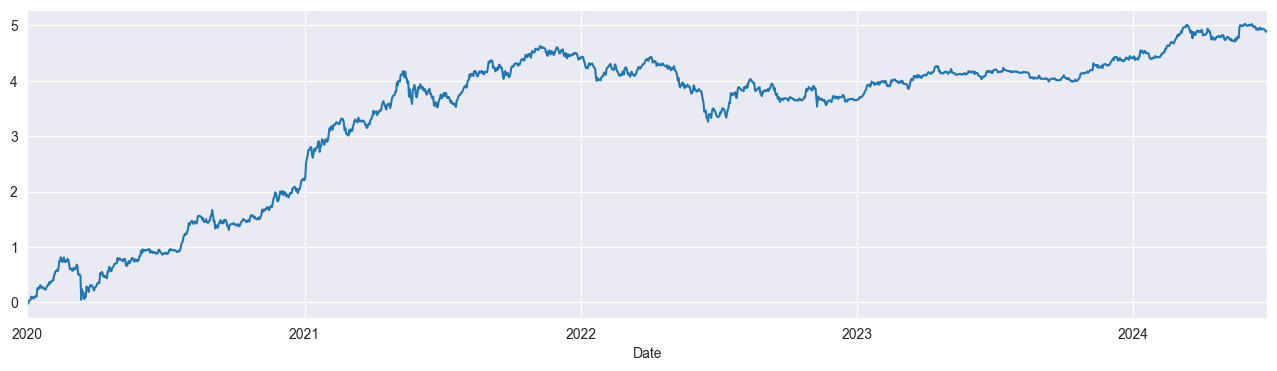

In [3]:
# plotting the cummulative return
np.cumsum(eth.Close.pct_change()).plot()

In [4]:
# Daily average return of ETH
print(eth.Close.pct_change().mean())

# Annualized average return - Crypto market trader on 365 days hence we take 365
print(f"Annualized average return: {eth.Close.pct_change().mean() * 365}")

# Annualized volatility 
print(f"Annualized volatility: {eth.Close.pct_change().std() * np.sqrt(365)}")

# Sharp Ratio
sharp_ratio = (eth.Close.pct_change().mean() * 365) / (eth.Close.pct_change().std() * np.sqrt(365))
print(f"Sharp Ratio: {sharp_ratio}")

0.0029852780058428267
Annualized average return: 1.0896264721326319
Annualized volatility: 0.8455474016873742
Sharp Ratio: 1.2886639707699101


<Axes: >

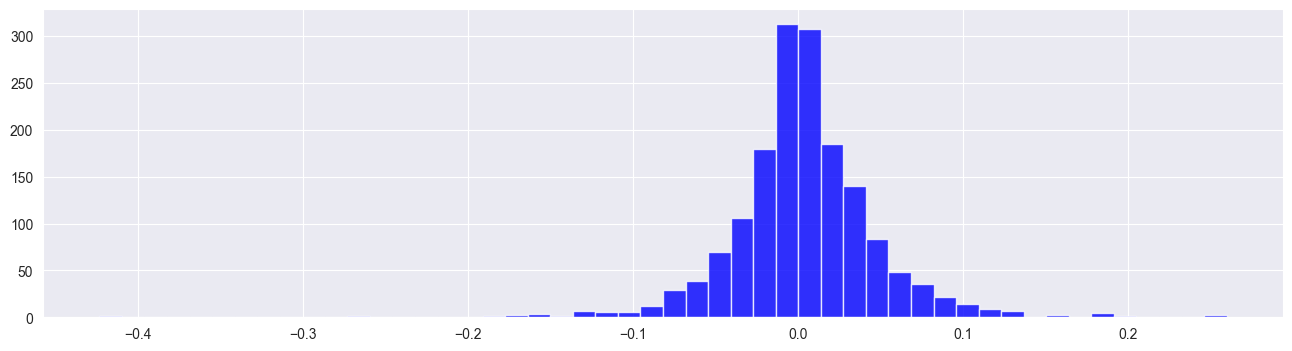

In [5]:
# Return distribution
eth['return'].hist(bins=50, color='b', alpha=0.8)

In [6]:
print(f"Skewness of eth return: {skew(eth['return'].dropna())}")
print(f"Kurtosis of Eth return: {kurtosis(eth['return'].dropna())}")

Skewness of eth return: -0.36253399779580914
Kurtosis of Eth return: 9.022725516698014


- Higher Kurtosis suggest, more extreme outlier 
- Negative but close 0 skewness suggest the distribution is asymmetrical
- Based on the return distribution we can employe the mean-reversion strategy 

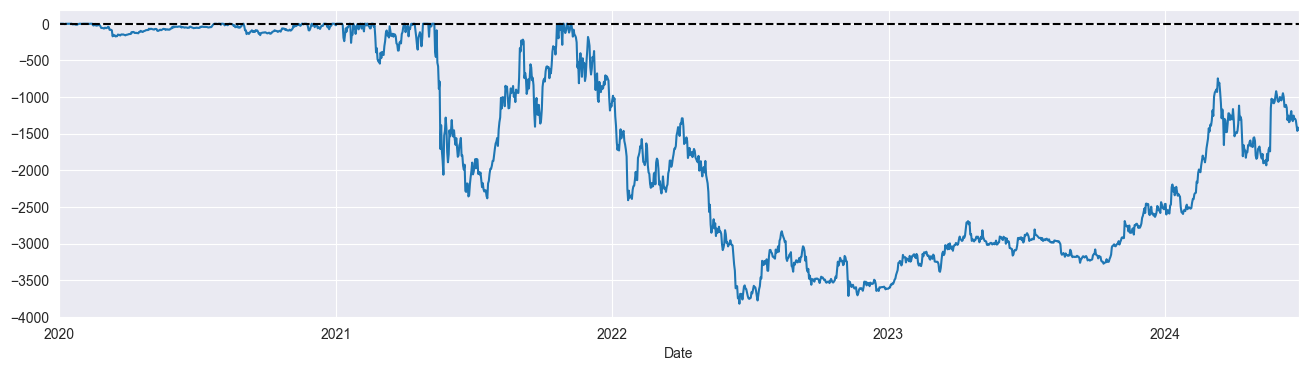

In [7]:
# Drawdown in dollar term of ETH 
(eth.Close - eth.Close.expanding().max()).plot()
plt.axhline(y=0, color='black', linestyle='--')

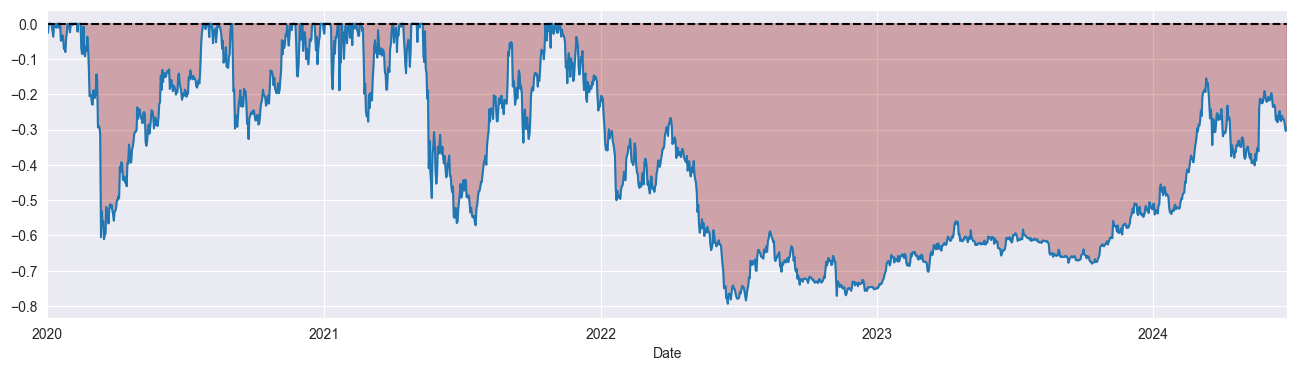

In [8]:
# Drawdown in percentage term of ETH 
plt.figure(figsize=(16,4))
(((eth.Close / eth.Close.expanding().max()))-1).plot()
plt.axhline(y=0, color='black', linestyle='--')

# fill between the drawdown line
plt.fill_between(eth.index, 0, (((eth.Close / eth.Close.expanding().max()))-1), where=(((eth.Close / eth.Close.expanding().max()))-1) < 0, color='darkred', alpha=0.3)

In [9]:
# Maximum Drawdown in percentage
print((eth.Close / eth.Close.expanding().max()-1).min())

# Maximum Drawdown in dollar
print((eth.Close - eth.Close.expanding().max()).min())

-0.7935123166505245
-3818.4506225585938


In [10]:
# using the qunatstats to analyse the buy and hold strategy
import quantstats as qs

qs.reports.metrics(eth['return'], annualized=True)

                    Strategy
------------------  ----------
Start Period        2020-01-02
End Period          2024-06-26
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   2,476.01%
CAGR﹪              64.89%

Sharpe              1.07
Prob. Sharpe Ratio  99.64%
Sortino             1.58
Sortino/√2          1.12
Omega               1.22

Max Drawdown        -79.35%
Longest DD Days     961

Gain/Pain Ratio     0.22
Gain/Pain (1M)      1.64

Payoff Ratio        1.1
Profit Factor       1.22
Common Sense Ratio  1.38
CPC Index           0.71
Tail Ratio          1.13
Outlier Win Ratio   3.91
Outlier Loss Ratio  4.15

MTD                 -10.39%
3M                  -6.17%
6M                  48.27%
YTD                 47.69%
1Y                  77.29%
3Y (ann.)           10.71%
5Y (ann.)           64.89%
10Y (ann.)          64.89%
All-time (ann.)     64.89%

Avg. Drawdown       -11.35%
Avg. Drawdown Days  39
Recovery Factor     6.16
Ulcer Index         0.46
Serenity Index 

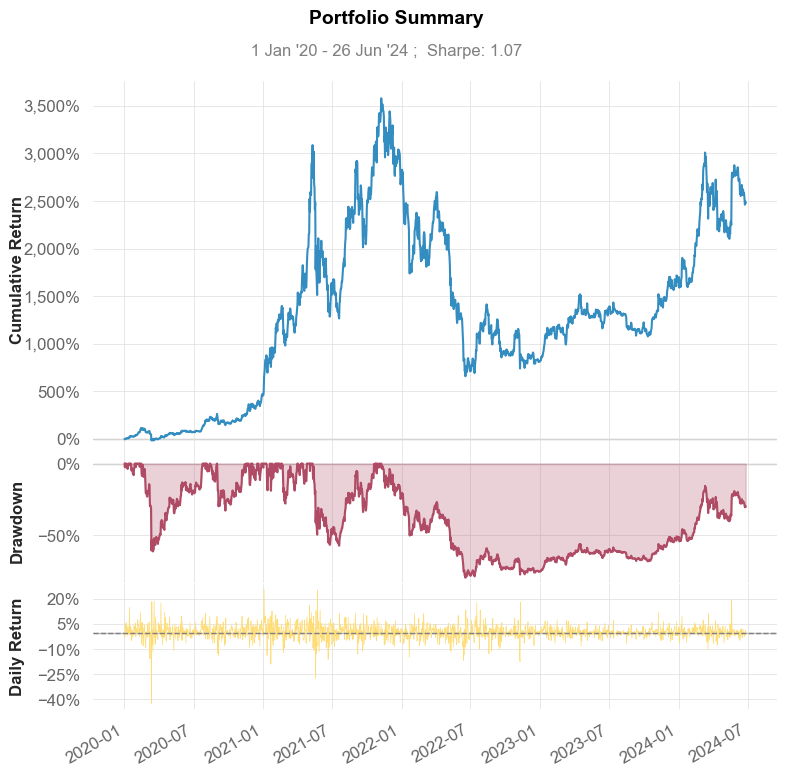

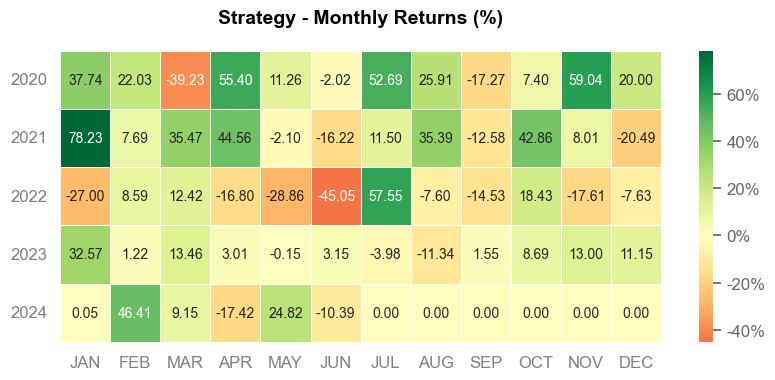

In [11]:
# visualize the strategy
qs.reports.plots(eth['return'])

Total number of trades: 83
Total PnL: 3220.59
profit per trade:38.80


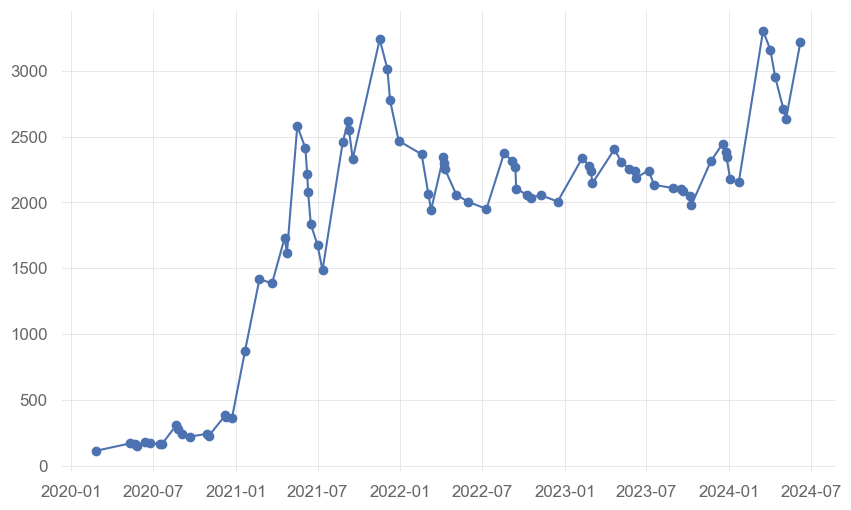

In [12]:
# Desinging the quantative mean reversion strategy 

# Simple Mean Reversion Strategy with long only strategy

inpos = 0
entry = 0
pnls = []   # profit and loss of each trade
dates = []  # date of trade

for i in range(len(eth.Close)):
    if inpos == 0:
        # long trade entry
        if ma[i] < eth.Close[i]:
            inpos = 1
            entry = eth.Close[i]

    elif inpos == 1:
        # long trade exit
        if ma[i] > eth.Close[i]:
            inpos = 0
            pnls.append(eth.Close[i] - entry)
            dates.append(eth.index[i])

print(f"Total number of trades: {len(pnls)}")
print(f"Total PnL: {np.cumsum(pnls)[-1]:.2f}")
print(f"profit per trade:{np.mean(pnls):.2f}")
plt.plot(dates, np.cumsum(pnls), '-o')

Total number of trades: 140
Total PnL: 3986.21
profit per trade:28.47


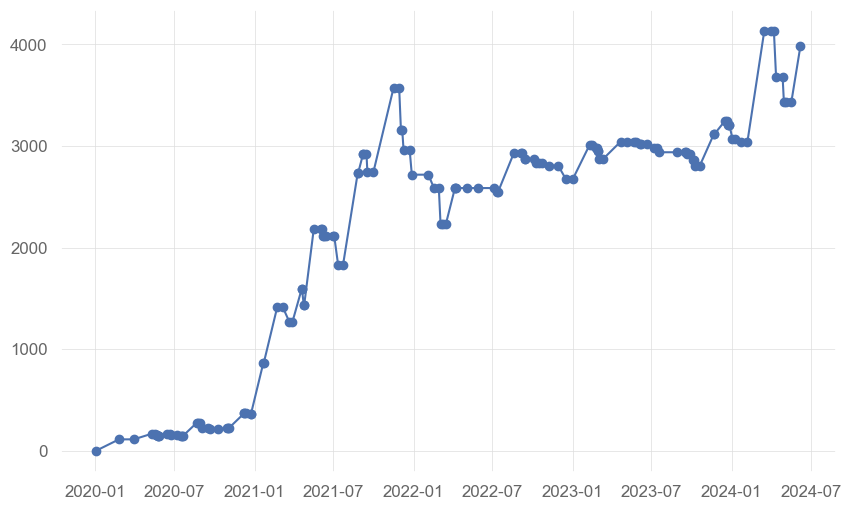

In [13]:
# Desinging the quantative mean reversion strategy 

# Simple Mean Reversion Strategy with long and short 

inpos = 0
entry = 0
pnls = []   # profit and loss of each trade
dates = []  # date of trade

for i in range(len(eth.Close)):
    if inpos == 0:
        # long trade entry
        if eth.ma[i] < eth.Close[i]:
            inpos = 1
            entry = eth.Close[i]

    elif inpos == 1:
        # long trade exit
        if eth.ma[i] > eth.Close[i]:
            inpos = 0
            pnls.append(eth.Close[i] - entry)
            dates.append(eth.index[i])
    
    if inpos == 0:
        # short trade entry
        if eth.ma[i] > eth.Close[i]:
            inpos = -1
            entry = eth.Close[i]

    elif inpos == -1:
        # short trade exit
        if eth.ma[i] < eth.Close[i]:
            inpos = 0
            pnls.append((entry - eth.Close[i]) * inpos )
            dates.append(eth.index[i])

print(f"Total number of trades: {len(pnls)}")
print(f"Total PnL: {np.cumsum(pnls)[-1]:.2f}")
print(f"profit per trade:{np.mean(pnls):.2f}")
plt.plot(dates, np.cumsum(pnls), '-o')

- By using the short our pnls get enhanced, as depicted above chart

Total number of trades: 247
Total PnL: 3738.33
profit per trade:15.13


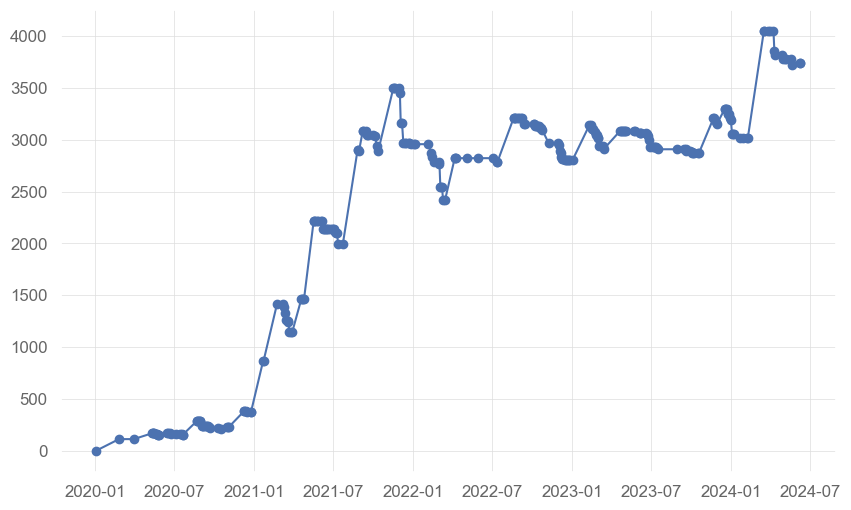

In [14]:
# enhance the strategy using the hard exit (taking the profit with percetage e.g. 5%)

inpos = 0
entry = 0
pnls = []   # profit and loss of each trade
dates = []  # date of trade

for i in range(len(eth.Close)):
    
    # validate if ma is not nan 
    if np.isnan(eth.ma[i]):
        continue

    if inpos == 0:
        # long trade entry
        if eth.ma[i] < eth.Close[i]:
            inpos = 1
            entry = eth.Close[i]

    elif inpos == 1:
        # long trade exit with hard exit (5% profit)
        if eth.ma[i] > eth.Close[i] or ((entry - eth.Close[i])*inpos > 0.05):
            inpos = 0
            pnls.append(eth.Close[i] - entry)
            dates.append(eth.index[i])
    
    if inpos == 0:
        # short trade entry
        if eth.ma[i] > eth.Close[i]:
            inpos = -1
            entry = eth.Close[i]

    elif inpos == -1:
        # short trade exit with hard exit (5% profit)
        if eth.ma[i] < eth.Close[i] or ((entry - eth.Close[i])*inpos > 0.05):
            inpos = 0
            pnls.append((entry - eth.Close[i]) * inpos )
            dates.append(eth.index[i])

print(f"Total number of trades: {len(pnls)}")
print(f"Total PnL: {np.cumsum(pnls)[-1]:.2f}")
print(f"profit per trade:{np.mean(pnls):.2f}")
plt.plot(dates, np.cumsum(pnls), '-o')

Total number of trades: 109
Total PnL: 2525.92
profit per trade:23.17


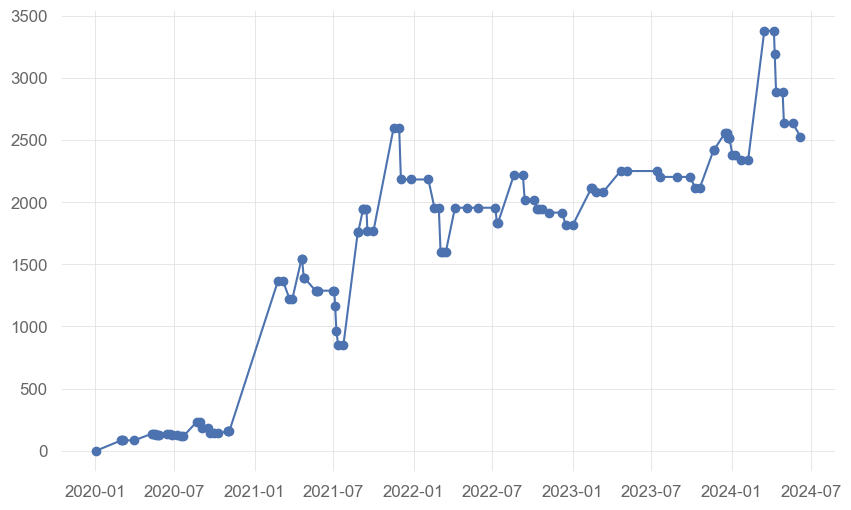

In [15]:
#  enhace the strategy using the hard exit (taking the profit with percetage e.g. 5%) and aviode the repetitive trade 

inpos = 0
entry = 0
pnls = []   # profit and loss of each trade
dates = []  # date of trade

for i in range(len(eth.Close)):
    price = eth.Close[i]
    ma = eth.ma[i]

    # validating the ma is not naa 

    if np.isnan(ma):
        continue


    if inpos == 0:
        # long entry
        if price > ma:
            inpos = 1
            entry = price

    elif inpos == 1:
        # long exit
        if price < ma and eth.Close[1-i] > eth.ma[1-i] or ((entry - price) / price * inpos > 0.05):
            inpos = 0
            pnls.append(price - entry)
            dates.append(eth.index[i])
    
    if inpos == 0:
        # short entry
        if price < ma:
            inpos = -1
            entry = price

    elif inpos == -1:
        # short exit
        if price > ma and eth.Close[1-i] < eth.ma[1-i] or ((entry - price) / price * inpos > 0.05):
            inpos = 0
            pnls.append((entry - price) * inpos )
            dates.append(eth.index[i])

print(f"Total number of trades: {len(pnls)}")
print(f"Total PnL: {np.cumsum(pnls)[-1]:.2f}")
print(f"profit per trade:{np.mean(pnls):.2f}")
plt.plot(dates, np.cumsum(pnls), '-o')        


Total number of trades: 87
Total PnL: 2634.96
profit per trade:30.29


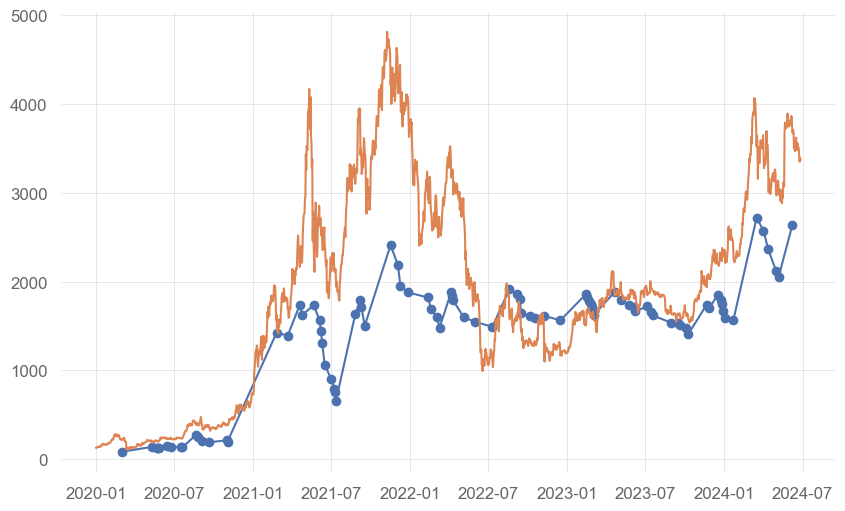

In [23]:
#  enhace the strategy using the hard exit (taking the profit with percetage e.g. 5%) and aviode the repetitive trade and take long only position 

inpos = 0   # Track position (0: no position, 1: long, -1: short)
entry = 0   # Entry price   
pnls = []   # profit and loss of each trade
dates = []  # date of trade

for i in range(len(eth.Close)):
    price = eth.Close[i]
    ma = eth.ma[i]

    # validating the ma is not naa 

    if np.isnan(ma):
        continue

    if inpos == 0:
        # long entry
        if price > ma:
            inpos = 1
            entry = price

    elif inpos == 1:
        # long exit
        if price < ma and eth.Close[1-i] > eth.ma[1-i] or ((entry - price) / price * inpos > 0.015):
            inpos = 0
            pnls.append(price - entry)
            dates.append(eth.index[i])

print(f"Total number of trades: {len(pnls)}")
print(f"Total PnL: {np.cumsum(pnls)[-1]:.2f}")
print(f"profit per trade:{np.mean(pnls):.2f}")
plt.plot(dates, np.cumsum(pnls), '-o')
plt.plot(eth.Close)


[*********************100%%**********************]  1 of 1 completed

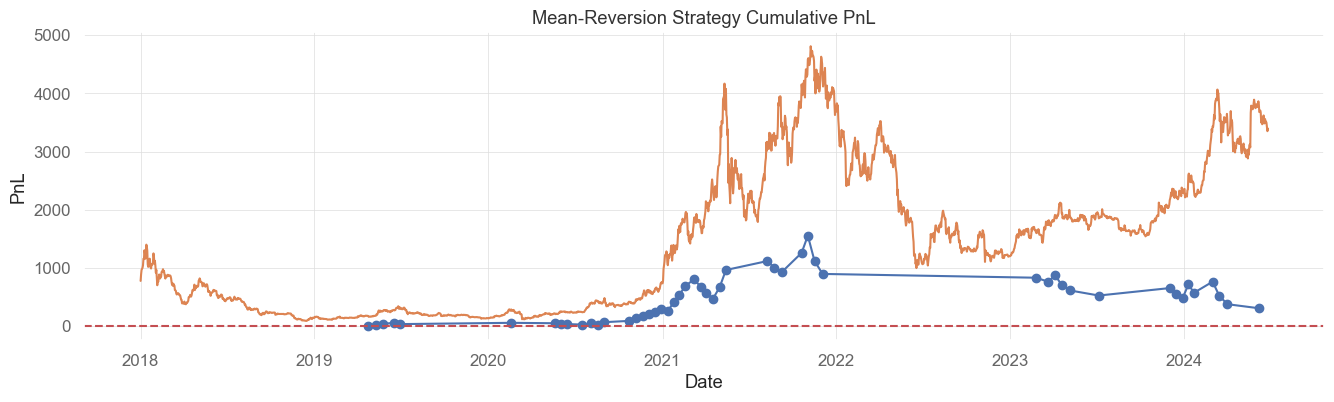

Total number of trades: 51
Total PnL: 301.13
Profit per trade: 5.90


In [26]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch data
eth = yf.download('ETH-USD', start='2018-01-01', end='2024-06-26')

# Calculate moving averages and additional indicators
eth['ma20'] = eth['Close'].rolling(window=20).mean()
eth['ma50'] = eth['Close'].rolling(window=50).mean()
eth['ma200'] = eth['Close'].rolling(window=200).mean()
eth['rsi'] = 100 - (100 / (1 + eth['Close'].pct_change().rolling(window=14).apply(lambda x: (x[x > 0].mean() / (-x[x < 0].mean() if len(x[x < 0]) > 0 else 1)), raw=True)))

# Initialize variables
inpos = 0
entry = 0
stop_loss_pct = 0.03  # 3% stop loss
take_profit_pct = 0.05  # 5% take profit
pnls = []   # profit and loss of each trade
dates = []  # date of trade
cooldown = 10  # cooldown period in days after a trade
cooldown_counter = 0  # counter to track cooldown period

# Loop over the data
for i in range(1, len(eth)):
    price = eth['Close'].iloc[i]
    ma20 = eth['ma20'].iloc[i]
    ma50 = eth['ma50'].iloc[i]
    ma200 = eth['ma200'].iloc[i]
    rsi = eth['rsi'].iloc[i]

    if np.isnan(ma20) or np.isnan(ma50) or np.isnan(ma200) or np.isnan(rsi):
        continue

    if cooldown_counter > 0:
        cooldown_counter -= 1
        continue

    if inpos == 0:
        # Long entry: Confirmed uptrend and RSI not overbought
        if price > ma20 and ma20 > ma50 and ma50 > ma200 and rsi < 70:
            inpos = 1
            entry = price

    elif inpos == 1:
        # Long exit: Price below MA20 or take profit or stop loss
        if (price < ma20 and eth['Close'].iloc[i-1] > eth['ma20'].iloc[i-1]) or ((price - entry) / entry > take_profit_pct) or ((price - entry) / entry < -stop_loss_pct):
            inpos = 0
            exit = price
            pnl = exit - entry
            pnls.append(pnl)
            dates.append(eth.index[i])
            cooldown_counter = cooldown

# Plot cumulative PnL
plt.figure(figsize=(16, 4))
plt.plot(dates, np.cumsum(pnls), '-o')
plt.plot(eth['Close'])
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Mean-Reversion Strategy Cumulative PnL')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.show()

# Print trade statistics
print(f"Total number of trades: {len(pnls)}")
print(f"Total PnL: {np.sum(pnls):.2f}")
print(f"Profit per trade: {np.mean(pnls):.2f}")

